#LAB 3  - REDES GANs
Nombre: Ariel Rodrigo Colque Garcia
* *Dataset*: STL10.- Es un conjunto de datos de imágenes de 10 clases, que consta de un total de 13,000 imágenes en color de 96x96 píxeles. Cada imagen está etiquetada con una de las 10 clases posibles: 

        1. avión
        2. automóvil
        3. pájaro
        4. gato
        5. ciervo
        6. perro
        7. rana
        8. caballo
        9. barco
        10. camión



El conjunto de datos STL10 se divide en 2 partes: entrenamiento y prueba. La parte de entrenamiento consta de 5,000 imágenes etiquetadas y la parte de prueba consta de 8,000 imágenes etiquetada

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch

# Descargar el conjunto de datos y aplicar transformaciones
# stl10_dataset = datasets.STL10(root='./data', split='train', download=True)

# Carga de los Datos
Debido a que el conjunto de datos STL10 consta de solo 5,000 imágenes para entrenamiento, se ha tomado la decisión de combinar los datos de entrenamiento y prueba en un solo conjunto de datos. Al hacer esto, hemos aumentado el tamaño del conjunto de datos a 13,000 imágenes, lo que nos permitirá entrenar nuestro modelo con más datos y mejorar potencialmente su capacidad de generalización.

In [ ]:
# Concatenacion de los datos train y test
train_dataset = datasets.STL10(root="./data", split='train', download=True)
test_dataset = datasets.STL10(root="./data", split='test', download=True)

full_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Creamos sus clases
classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Clase Dataset

In [ ]:
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, trainset):
        # normaliza las imágenes y las convierte en torch tensor
        self.imgs = torch.tensor([np.array(i[0]).transpose((2, 0, 1)) / 255. for i in trainset], dtype=torch.float, device=device)

        # convierte las etiquetas en torch tensor
        self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)

    def __len__(self):
        # toma el tamaño de las imágenes
        return len(self.imgs)

    def __getitem__(self, ix):
        # devuelve la imagen y su etiqueta correspondiente
        return self.imgs[ix], self.labels[ix]


# creamos el dataset
train = Dataset(full_dataset)
len(train)

<ipython-input-6-a969b4c77166>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  self.imgs = torch.tensor([np.array(i[0]).transpose((2, 0, 1)) / 255. for i in trainset], dtype=torch.float, device=device)


13000

In [ ]:
# prueba
img, label = train[10]
# normalizados
img.shape, img.dtype, img.max(), img.min()

(torch.Size([3, 96, 96]),
 torch.float32,
 tensor(1., device='cuda:0'),
 tensor(0., device='cuda:0'))

Crear Dataloader

In [ ]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=0)
imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 3, 96, 96]), torch.Size([32]))

# Visualizacion de las imagenes.

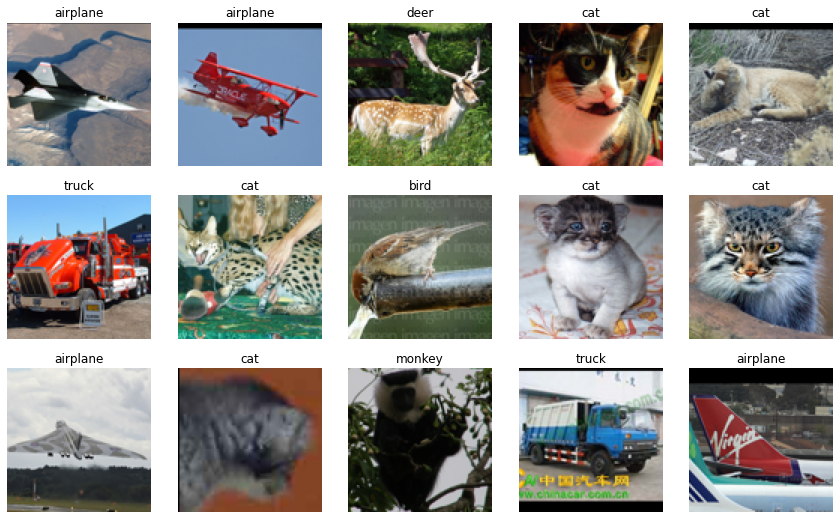

In [ ]:
import random 
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(train)-1)
        img, label = train[ix]
        plt.imshow(img.reshape(3, 96, 96).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.title(classes[label.item()])
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()


# GENERADOR

In [ ]:
import torch.nn as nn

# Definir el tamaño del vector latente
nz = 100

# Definir la clase del generador DCGAN
class DCGANGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # Primera capa: recibe un vector latente de tamaño nz y lo transforma en una imagen de 4x4x256
        self.inp = nn.Sequential(
            nn.ConvTranspose2d(nz, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        # Capas restantes: reciben una imagen y la transforman en otra de mayor resolución
        self.main = nn.Sequential(
            # Segunda capa: recibe una imagen de 4x4x256 y la transforma en una imagen de 8x8x128
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Tercera capa: recibe una imagen de 8x8x128 y la transforma en una imagen de 16x16x64
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Cuarta capa: recibe una imagen de 16x16x64 y la transforma en una imagen de 32x32x32
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # Quinta capa: recibe una imagen de 32x32x32 y la transforma en una imagen de 96x96x3
            nn.ConvTranspose2d(32, 3, kernel_size=5, stride=3, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        # Recibe un vector latente de tamaño nz
        x = x.view(-1, nz, 1, 1)
        # Aplica la primera capa
        x = self.inp(x)
        # Aplica las capas restantes
        x = self.main(x)
        # Devuelve una imagen de tamaño 64x64x3
        x = x.view(x.size(0), 3, 96, 96)
        return x

In [ ]:
generator = DCGANGenerator()

output = generator(torch.randn(16, 100))
print(output.shape)

torch.Size([16, 3, 96, 96])


#Discriminador

In [ ]:
import torch.nn as nn

# Definir la clase del discriminador DCGAN
class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Capas principales: reciben una imagen y la transforman en otra de menor resolución
        self.main = nn.Sequential(
            # Primera capa: recibe una imagen de 96x96x3 y la transforma en una imagen de 48x48x32
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Segunda capa: recibe una imagen de 48x48x32 y la transforma en una imagen de 24x24x64
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # Tercera capa: recibe una imagen de 24x24x64 y la transforma en una imagen de 12x12x128
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Cuarta capa: recibe una imagen de 12x12x128 y la transforma en una imagen de 6x6x256
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Capa de salida: recibe un vector y lo transforma en un valor escalar entre 0 y 1
        self.out = nn.Sequential(
            # Cambiar el tamaño del vector de entrada a 256 * 6 * 6
            nn.Linear(256 * 6 * 6, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Recibe una imagen de tamaño 96x96x3
        x = self.main(x)
        # Cambia el tamaño del vector a 256 * 6 * 6
        x = x.view(x.size(0), -1)
        # Aplica la capa de salida
        x = self.out(x)
        # Devuelve un valor escalar entre 0 y 1
        return x

In [ ]:
discriminator = DCGANDiscriminator()
output = discriminator(torch.randn(16, 3, 96, 96))
print(output.shape)

torch.Size([16, 1])


# ENTRENAMIENTO

In [ ]:
def train_gan(generator, discriminator, dataloader, num_epochs=300, checkpoint_path=None):
    # función de pérdida binaria cruzada
    criterion = nn.BCELoss()

    # optimizadores para el generador y el discriminador
    optimizer_g = torch.optim.Adam(generator.parameters(), lr= 0.0001, betas=(0.5, 0.999))
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr= 0.0001, betas=(0.5, 0.999))

    # etiquetas verdaderas y falsas para el discriminador
    real_label = 1
    fake_label = 0

    # lista para almacenar la pérdida del generador y el discriminador
    hist = {'g_loss': [], 'd_loss': []}
    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(dataloader):
            # tamaño del lote
            batch_size = imgs.size(0)

            # etiquetas verdaderas y falsas para el discriminador
            real_labels = torch.full((batch_size,), real_label, device=device).float()
            fake_labels = torch.full((batch_size,), fake_label, device=device).float()

            # entrenamiento del discriminador con imágenes reales
            discriminator.zero_grad()
            real_output = discriminator(imgs.to(device)).view(-1)
            d_loss_real = criterion(real_output, real_labels)

            # entrenamiento del discriminador con imágenes falsas generadas por el generador
            noise = torch.randn(batch_size, 100, device=device)
            fake_imgs = generator(noise)
            fake_output = discriminator(fake_imgs.detach()).view(-1)
            d_loss_fake = criterion(fake_output, fake_labels)

            # actualización de los pesos del discriminador
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()

            # entrenamiento del generador para engañar al discriminador
            generator.zero_grad()
            fake_output = discriminator(fake_imgs).view(-1)
            g_loss = criterion(fake_output, real_labels)

            # actualización de los pesos del generador
            g_loss.backward()
            optimizer_g.step()

        # almacenamiento de la pérdida del generador y el discriminador en cada época
        hist['g_loss'].append(g_loss.item())    
        hist['d_loss'].append(d_loss.item())

        print(f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")
        if checkpoint_path is not None and (epoch+1) % 10 == 0:
            torch.save({
                'epoch': epoch+1,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'generator_optimizer_state_dict': optimizer_g.state_dict(),
                'discriminator_optimizer_state_dict': optimizer_d.state_dict(),
                'generator_loss': g_loss.item(),
                'discriminator_loss': d_loss.item(),
            }, checkpoint_path)
    return hist


In [ ]:
# 300 epocas
generator = generator.to(device)
discriminator = discriminator.to(device)
checkpoint_path = '/content/drive/MyDrive/Data/Checkpoint/entrenamiento1.tar'

hist = train_gan(generator, discriminator, dataloader, checkpoint_path=checkpoint_path)

Epoch [1/300], Discriminator Loss: 0.0129, Generator Loss: 8.9505
Epoch [2/300], Discriminator Loss: 0.2580, Generator Loss: 13.8247
Epoch [3/300], Discriminator Loss: 0.1786, Generator Loss: 13.1226
Epoch [4/300], Discriminator Loss: 0.3667, Generator Loss: 1.0590
Epoch [5/300], Discriminator Loss: 0.0125, Generator Loss: 7.5451
Epoch [6/300], Discriminator Loss: 0.0743, Generator Loss: 7.9840
Epoch [7/300], Discriminator Loss: 0.1632, Generator Loss: 4.5639
Epoch [8/300], Discriminator Loss: 0.6870, Generator Loss: 22.9500
Epoch [9/300], Discriminator Loss: 0.0205, Generator Loss: 6.8801
Epoch [10/300], Discriminator Loss: 0.0941, Generator Loss: 8.7493
Epoch [11/300], Discriminator Loss: 0.3094, Generator Loss: 4.1047
Epoch [12/300], Discriminator Loss: 0.0151, Generator Loss: 6.8624
Epoch [13/300], Discriminator Loss: 0.0777, Generator Loss: 8.9497
Epoch [14/300], Discriminator Loss: 0.0369, Generator Loss: 7.0206
Epoch [15/300], Discriminator Loss: 0.0040, Generator Loss: 9.5507
E

# GRAFICO DE PERDIDAS (loss)

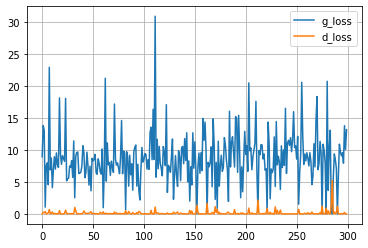

In [ ]:
# 300
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

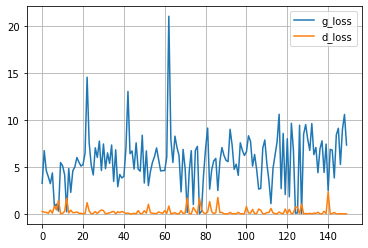

In [ ]:
# 150 epocas
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

# GENERACION DE IMAGENES

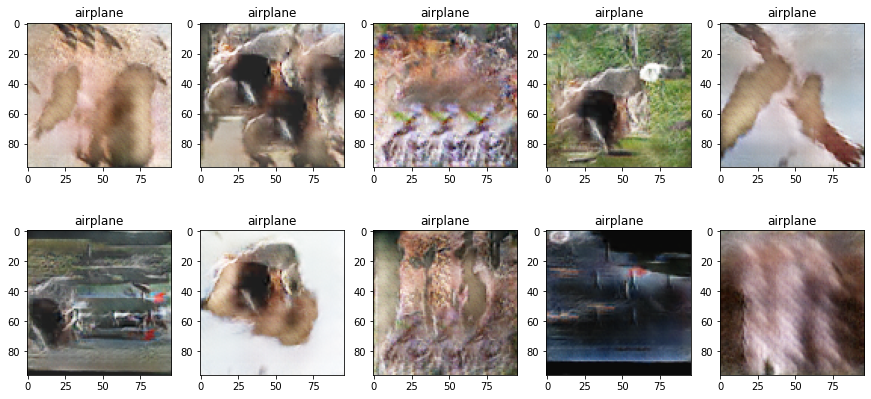

In [ ]:
# con 150 epocas
import random 

# generamos las imagenes
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, 100), device=device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,7))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].permute(1, 2, 0).cpu()
      img = (img - img.min()) / (img.max() - img.min()) 
      class_idx = torch.argmax(discriminator(generated_images[i].unsqueeze(0).to(device)))
      _ax.set_title(classes[class_idx])
      _ax.imshow(img.permute(2, 0, 1).permute(1, 2, 0), vmin=0, vmax=1)
      i+=1
  plt.show()


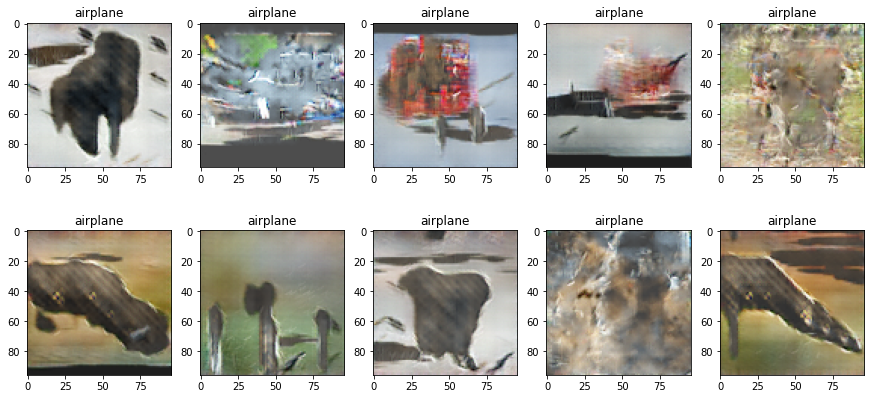

In [ ]:
# 300 epocas
import random 

# generamos las imagenes
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, 100), device=device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,7))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].permute(1, 2, 0).cpu()
      img = (img - img.min()) / (img.max() - img.min()) 
      class_idx = torch.argmax(discriminator(generated_images[i].unsqueeze(0).to(device)))
      _ax.set_title(classes[class_idx])
      _ax.imshow(img.permute(2, 0, 1).permute(1, 2, 0), vmin=0, vmax=1)
      i+=1
  plt.show()

In [ ]:
# 800 epocas
generator = generator.to(device)
discriminator = discriminator.to(device)
checkpoint_path = '/content/drive/MyDrive/Data/Checkpoint/entrenamiento2.tar'
num_epochs=800

hist = train_gan(generator, discriminator, dataloader, num_epochs=num_epochs, checkpoint_path=checkpoint_path)

Epoch [1/800], Discriminator Loss: 0.1260, Generator Loss: 5.1031
Epoch [2/800], Discriminator Loss: 1.1593, Generator Loss: 2.6257
Epoch [3/800], Discriminator Loss: 0.5370, Generator Loss: 5.0324
Epoch [4/800], Discriminator Loss: 0.9289, Generator Loss: 1.8126
Epoch [5/800], Discriminator Loss: 0.3257, Generator Loss: 6.4908
Epoch [6/800], Discriminator Loss: 1.3822, Generator Loss: 8.8787
Epoch [7/800], Discriminator Loss: 0.4085, Generator Loss: 2.3402
Epoch [8/800], Discriminator Loss: 0.0381, Generator Loss: 4.3225
Epoch [9/800], Discriminator Loss: 0.4156, Generator Loss: 2.4517
Epoch [10/800], Discriminator Loss: 0.3120, Generator Loss: 3.5425
Epoch [11/800], Discriminator Loss: 0.9288, Generator Loss: 1.6975
Epoch [12/800], Discriminator Loss: 0.3364, Generator Loss: 1.1373
Epoch [13/800], Discriminator Loss: 1.1220, Generator Loss: 0.2513
Epoch [14/800], Discriminator Loss: 0.2070, Generator Loss: 3.9798
Epoch [15/800], Discriminator Loss: 0.8672, Generator Loss: 1.4934
Epoc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
